<img src="../images/mosquito.jpg" width="1000" />

# <span style="color:#37535e">Healthy Chicago: West Nile Virus Prediction</span>

### <span style="color:#3b748a">Authors: Scott Wright, Alfred Lopez, Gwyneth Butera</span>
    
<span style="color:#3b748a">Given weather, location, testing, and spraying data, this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus.</span>

<a href="https://www.kaggle.com/c/predict-west-nile-virus">https://www.kaggle.com/c/predict-west-nile-virus</a>

## <span style='color:#3b748a'>Table of contents</span>
* <a href="#step1"><span style='color:#4095b5'>Define the problem</span></a>
* <a href="#step2"><span style='color:#4095b5'>Obtain the data</span></a>
* <a href="#step3"><span style='color:#4095b5'>Explore the data</span></a>
* <a href="#step4"><span style='color:#4095b5'>Model the data</span></a>
* <a href="#step5"><span style='color:#4095b5'>Evaluate the model</span></a>
* <a href="#step6"><span style='color:#4095b5'>Answer the problem</span></a>
* <a href="#step7"><span style='color:#4095b5'>More modeling</span></a>
* <a href="#step8"><span style='color:#4095b5'>Future work</span></a>
* <a href="#step9"><span style='color:#4095b5'>For reference</span></a>

## <span style='color:#3b748a'>Links</span>
* <a href="../slides.pptx"><span style='color:#4095b5'>Slide presentation</span></a>
* <a href="https://github.com/gbkgwyneth/GA-DSI-project-04"><span style='color:#4095b5'>On GitHub</span></a>
* <a href="https://drive.google.com/open?id=1q-Tp-zzgZEtVuaDiUyzpCS9frsOv1DTB&usp=sharing"><span style='color:#4095b5'>Spray map</span></a>
* <a href="https://drive.google.com/open?id=1YyD5x8lXDe_t8fzrf6DpMOYlsMF8wGzl&usp=sharing"><span style='color:#4095b5'>Spray 2011-09-07 map</span></a>
* <a href="https://git.generalassemb.ly/gwynethbutera/ATL-gas-the-vectors"><span style='color:#4095b5'>Traps map</span></a>
<hr>

In [1]:
# Let's get the administrative stuff done first
# import all the libraries and set up the plotting

import pandas as pd
import numpy as np
from datetime import datetime,timedelta

import statsmodels.api as sm

from sklearn.cluster import KMeans, k_means
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import accuracy_score, mean_squared_error, silhouette_score, roc_auc_score

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV 
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(style="white", color_codes=True)
colors_palette = sns.color_palette("GnBu_d")
sns.set_palette(colors_palette)

# GnBu_d
colors = ['#37535e', '#3b748a', '#4095b5', '#52aec9', '#72bfc4', '#93d0bf']

/Users/gwyneth/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## <span style='color:#3b748a'>Data checking functions</span>

In [2]:
# Check which non-numeric columns are missing values and what the possible values are for each object column

def check_cols(df):
    cols = df.select_dtypes([np.object]).columns
    for col in cols:
        print("{} is {} and values are {}.".format(col,df[col].dtype,df[col].unique()))
        n_nan = df[col].isnull().sum()
        if n_nan > 0:
            print("{} has {} NaNs.".format(col,n_nan))
            
    cols = df.select_dtypes([np.int64,np.float64,np.uint64]).columns
    for col in cols:
        print("{} is {} and values are {} to {}.".format(col,df[col].dtype,df[col].min(),df[col].max()))
        n_nan = df[col].isnull().sum()
        if n_nan > 0:
            print("{} has {} NaNs.".format(col,n_nan))
    return

In [3]:
# Check which numeric columns are missing values

def check_data(df):
    s = df.shape
    print("Rows: {} Cols: {}".format(s[0],s[1]))

    # Check for null values
    null_data = df.isnull().sum()
    null_data_count = sum(df.isnull().sum())
    if  null_data_count > 0:
        print("There are {} null data.".format(null_data_count))
        print("Columns with NaN: {}".format(list(null_data[null_data > 0].index)))

    duplicates = df[df.duplicated()].shape[0]
    print("There are {} duplicate rows in the test data.".format(duplicates))

    check_cols(df)

    return

In [4]:
def read_examine_df(file):
    df = pd.read_csv(file)
    check_data(df)
    return df

<hr>
 <a name="step1"></a>
 ## <span style="color:#37535e">I. Define the problem</span>
 
<span style='color:#3b748a'>Predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus.</span>

<span style='color:#3b748a'>For each record in the test set, you should predict a real-valued probability that WNV is present.</span>

<a name="step2"></a>
 ## <span style="color:#37535e">II. Obtain the data.</span>
 
<ul>
    <li><span style='color:#3b748a'>Training data: <span style="font-family:monospace">train.csv</span></span></li>
    <li><span style='color:#3b748a'>Test data: <span style="font-family:monospace">test.csv</span></span></li>
    <li><span style='color:#3b748a'>Spray data: <span style="font-family:monospace">spray.csv</span></span></li>
    <li><span style='color:#3b748a'>Weather data: <span style="font-family:monospace">weather.csv</span></span></li>
</ul>

### <span style='color:#3b748a'>Training data</span>
<ul>
    <li><span style='color:#4095b5'>Rows: 10506</span></li
        >
    <li><span style='color:#4095b5'>Cols: 12</span></li>
    <li><span style='color:#4095b5'>There is NO null data.</span></li>
</ul>

In [5]:
do_check_data = False

In [6]:
if do_check_data:
    df_train = read_examine_df("../data/train.csv")
else:
    df_train = pd.read_csv("../data/train.csv")

### <span style='color:#3b748a'>Cleaning the training data</span>
<ul>
    <li><span style='color:#4095b5'>Latitude and longitude have reasonable ranges.</span></li>
    <li><span style='color:#4095b5'>Drop all other address data for now.</span></li>
    <li><span style='color:#4095b5'>Replace <span style="font-family:monospace">Date</span>  with a <span style="font-family:monospace">datetime</span> object.</span></li>
    <li><span style='color:#4095b5'>Create <span style="font-family:monospace">Week</span> and <span style="font-family:monospace">Year</span> features.</span></li>
    <li><span style='color:#4095b5'>(Removed) Merge rows with same trap/date/species; sum <span style="font-family:monospace">NumMosquitos</span> and set <span style="font-family:monospace">WnvPresent</span> to 0 or 1 acordingly. This may cause us to lose some information. Scott and Al convinced Gwyneth that this is a bad idea overall. There might be some value in the aggregatingg if done at the right times.</span></li>
</ul>

In [7]:
# For now, drop all the address columns since lat/lon should be enough
df_train.drop(['Address','Block','Street','AddressNumberAndStreet','AddressAccuracy'], axis=1,inplace=True)

In [8]:
# Make Date into datetime
df_train['Date'] = pd.to_datetime(df_train['Date'])

# Add week and Year columns
df_train['Week'] = (df_train['Date'].dt.strftime('%W')).astype(int)
df_train['Year'] = (df_train['Date'].dt.strftime('%Y')).astype(int)

#### <span style='color:#4095b5'>(Removed) Aggregate split rows</span>

In [9]:
# The model works better without aggregating, but there maybe a use for it

# Merge duplicate rows by summing NumMosquiots and WMvPresent
# df_train = df_train.groupby(['Date','Week','Year','Species','Trap','Latitude', 'Longitude'], as_index=False).sum().reindex()
# Change WnvPresent to be  0/1
# df_train['WnvPresent'] = (df_train['WnvPresent'] > 0).astype(int)

#### <span style='color:#4095b5'>Plot mosquito totals by week and species</span>

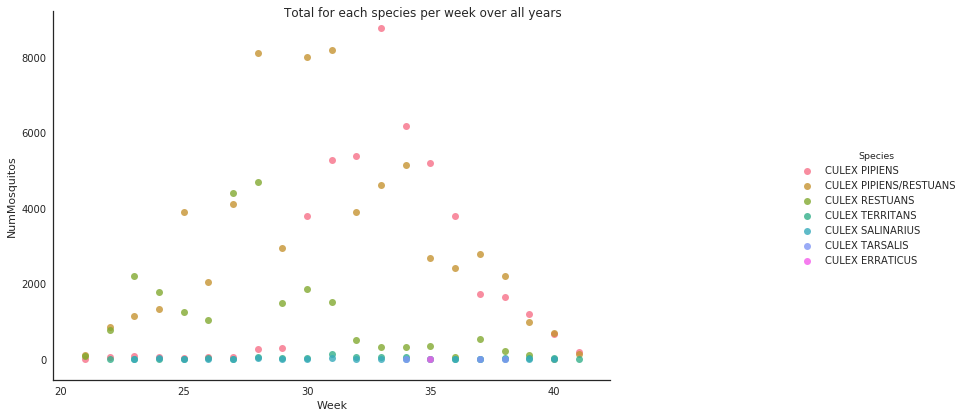

In [10]:
# This is the TOTAL mosquitos in a given week summed over all years.
df_temp = df_train.groupby(['Week','Species'], as_index=False).sum().reindex()

fg = sns.lmplot(data=df_temp, x = 'Week', y='NumMosquitos', hue='Species', fit_reg=False);
fg.fig.set_figheight(6)
fg.fig.set_figwidth(15)
fg.fig.suptitle("Total for each species per week over all years");

In [11]:
# Speies with West Nile Virus
species_wnv = set((df_train[df_train['WnvPresent'] > 0])['Species'])

### <span style='color:#3b748a'>Create "target" variables</span>

<span style='color:#4095b5'>There are TWO targets in this problem:</span>

<ul>
    <li><span style='color:#4095b5'>First, we have to predict HOW MANY mosquitoes of each species will be in a trap on a given date.</span></li>
    <li><span style='color:#4095b5'>Then we have to predict the probablity that there will be West Nile virus present based on those counts.</span></li>
</ul>

In [12]:
# Create our targets then drop those columns

y_count_label = 'NumMosquitos'
y_count = df_train[y_count_label]

y_wnv_label = 'WnvPresent'
y_wnv = df_train[y_wnv_label]

df_train.drop(columns=[y_wnv_label,y_count_label], inplace=True)

### <span style='color:#3b748a'>Kaggle data</span>
<ul>
    <li><span style='color:#4095b5'>Rows: 116293</span></li>
    <li><span style='color:#4095b5'>Cols: 11</span></li>
    <li><span style='color:#4095b5'>There is NO null data.</span></li>
</ul>

<span style='color:#4095b5'>The instructions say that we are predicting all combinations of possible traps/dates/species, but we will only be scored on the records that match with actual tests/samples.</span>

In [13]:
if do_check_data:
    df_kaggle = read_examine_df("../data/test.csv")
else:
    df_kaggle = pd.read_csv("../data/test.csv")

### <span style='color:#3b748a'>Cleaning the Kaggle data</span>
<ul>
    <li><span style='color:#4095b5'>Latitude and longitude have reasonable ranges.</span></li>
    <li><span style='color:#4095b5'>Drop all other address data for now.</span></li>
    <li><span style='color:#4095b5'>Replace <span style="font-family:monospace">Date</span>  with a <span style="font-family:monospace">datetime</span> object.</span></li>
    <li><span style='color:#4095b5'>Create <span style="font-family:monospace">Week</span> and <span style="font-family:monospace">Year</span> features.</span></li>
    <li><span style='color:#4095b5'>There are duplicate rows. Can we assume anything about these? We merged rows like this in training, but we need to make predictions here.</span></li>
</ul>    

<ul>
    <li><span style='color:#4095b5'>Does not have <span style="font-family:monospace">NumMosquitos</span> nor <span style="font-family:monospace">WnvPresent</span>. These are what we need to predict.</span></li>
    <li><span style='color:#4095b5'>Does have <span style="font-family:monospace">Id</span> column - later on, make this the index?</span></li>
</ul>

In [14]:
# For now, drop all the address columns since lat/lon should be enough
df_kaggle.drop(['Address','Block','Street','AddressNumberAndStreet','AddressAccuracy'], axis=1,inplace=True)

# Make Date into datetime
df_kaggle['Date'] = pd.to_datetime(df_kaggle['Date'])

# Add week and 'Year' feature
df_kaggle['Week'] = (df_kaggle['Date'].dt.strftime('%W')).astype(int)
df_kaggle['Year'] = (df_kaggle['Date'].dt.strftime('%Y')).astype(int)

In [15]:
# If there is a duplicate row, maybe that means we know there are more than 50 in trap?
kaggle_cols = list(df_kaggle.columns)
kaggle_cols.remove('Id')
duplicates = df_kaggle[df_kaggle.duplicated(kaggle_cols)].shape[0]
print("There are {} duplicate rows in the test data.".format(duplicates))

# There are 1533 duplicate rows in the test data.

There are 1533 duplicate rows in the test data.


In [16]:
df_kaggle.head()

,Id,Date,Species,Trap,Latitude,Longitude,Week,Year
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,23,2008
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,23,2008
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,23,2008
3,4,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,23,2008
4,5,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,23,2008


### <span style='color:#3b748a'>Cleaning the trap data</span>

<span style='color:#4095b5'>While working to feature engineer the spraying data, we noticed that there are two traps that each have two different locations listed in the observation data. We rename these traps and also rename them in the Kaggle test data.</span>

In [17]:
# Break apart duplicate traps !
df_traps_train = df_train[['Trap', 'Latitude','Longitude']].copy()
df_traps_train.drop_duplicates(inplace=True)
df_traps_train.reset_index(inplace=True)
print("There are {} traps in the test data.".format(df_traps_train.shape[0]))

# Here are the traps with duplicates
df_trap_duplicate = df_traps_train.loc[df_traps_train.duplicated('Trap')][['Trap','Latitude','Longitude']].copy()
if df_trap_duplicate.shape[0] > 0:
    print("There are {} bad traps in the training data. Now cleaning.".format(df_trap_duplicate.shape[0]))
    
# For each one, update the Train and Kaggle data too...
for i in df_trap_duplicate.index:
    trap = df_trap_duplicate.loc[i, "Trap"]
    lat = df_trap_duplicate.loc[i, "Latitude"]
    long = df_trap_duplicate.loc[i, "Longitude"]
    new_trap = trap + "GAS"
    df_train.loc[(df_train['Trap'] == trap) 
                 & (df_train['Latitude'] == lat) 
                 & (df_train['Longitude'] == long),'Trap'] = new_trap
    df_kaggle.loc[(df_kaggle['Trap'] == trap) 
                 & (df_kaggle['Latitude'] == lat) 
                 & (df_kaggle['Longitude'] == long),'Trap'] = new_trap

# Repeat with Kaggle data
df_traps_kaggle = df_kaggle[['Trap', 'Latitude','Longitude']].copy()
df_traps_kaggle.drop_duplicates(inplace=True)
df_traps_kaggle.reset_index(inplace=True)
print("There are {} traps in the Kaggle data.".format(df_traps_kaggle.shape[0]))

# Any more with duplicates
df_trap_duplicate = df_traps_kaggle.loc[df_traps_kaggle.duplicated('Trap')][['Trap','Latitude','Longitude']].copy()
if df_trap_duplicate.shape[0] > 0:
    print("There are {} bad traps in the Kaggle test data. Error: More cleaning needed.".format(df_trap_duplicate.shape[0]))

There are 138 traps in the test data.
There are 2 bad traps in the training data. Now cleaning.
There are 151 traps in the Kaggle data.


### <span style='color:#3b748a'>Spray data</span>
<ul>
    <li><span style='color:#4095b5'>Rows: 14835</span></li
        >
    <li><span style='color:#4095b5'>Cols: 4</span></li>
    <li><span style='color:#4095b5'>There are 584 null data.</span></li>
    <li><span style='color:#4095b5'>There are 541 duplicate rows.</span></li>
    <li><span style='color:#4095b5'>Columns with NaN: <span style="font-family:monospace">Time</span></span></li>
</ul>

In [18]:
if do_check_data:
    df_spray = read_examine_df("../data/spray.csv")
else: 
    df_spray = pd.read_csv("../data/spray.csv")
df_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


### <span style='color:#3b748a'>Cleaning the spray data</span>
<ul>
    <li><span style='color:#4095b5'>Latitude and longitude have reasonable ranges.</span></li>
    <li><span style='color:#4095b5'>Missing <span style="font-family:monospace">Time</span> data on date 2011-09-07</span></li>
    <li><span style='color:#4095b5'>Drop (~450) duplicate rows: <br />2011-09-07	7:44:32 PM	41.98646	-87.794225</span></li>
    <li><span style='color:#4095b5'>Add <span style="font-family:monospace">DateTime</span> column and change <span style="font-family:monospace">Date</span> to a <span style="font-family:monospace">datetime</span> object.</span></li>
</ul>

#### <span style='color:#4095b5'>Spraying maps</span>
<ul>
    <li><a href="https://drive.google.com/open?id=1q-Tp-zzgZEtVuaDiUyzpCS9frsOv1DTB&usp=sharing"><span style='color:#4095b5'>All the spraying data, execpt for the date with bad data</span></a></li>
    <li><a href="https://drive.google.com/open?id=1YyD5x8lXDe_t8fzrf6DpMOYlsMF8wGzl&usp=sharing"><span style='color:#4095b5'>Spray 2011-0907 map</span></a></li>

</ul>

<center><span style='color:#4095b5'>Map of all spraying except for 2011-09-07</span></center>
<img src="../images/spray-map.jpg" alt="Full spray map" width=700/>


<center><span style='color:#4095b5'>Map of all spraying on 2011-0907</span></center>
<img src="../images/spray-2011-09-07.jpg" alt="Spray map for 2011-09-07" width=700/>


### <span style='color:#3b748a'>Missing spray time data for 2011-09-07</span>
<ul>
    <li><span style='color:#4095b5'>Many <span style="font-family:monospace">Time</span> values are missing but can likely be imputed.</span></li>
    <li><span style='color:#4095b5'>Spraying generally happens every 10 seconds. </span></li>
    <li><span style='color:#4095b5'>As the previous rows were the duplicate data, I'm going to guess that we should connect with 7:44:32.</span>
    <li><span style='color:#4095b5'>Based the spray time on the endpoints.</span>
    <li><span style='color:#4095b5'>Probably good enough to have the time within a small window of time.</span>
        
</ul>

In [19]:
# This spray time imputation is overkill, but it was fun to tackle.

# Get time of duplicate row
# Make it the start for the next set of columns
# fill the NaNs, *subtracting* ten seconds based on the map of the missing data

# Get time of duplicate row
series = df_spray[df_spray.duplicated() == True].index
idx = series[-1]

# Check the next row starts the Nans
# print("If it is not a NaN, we have a problem... {}".format(df_spray.loc[idx+1]['Time']))

# Assume the NaNs are in a row
null_data_count = sum(df_spray.isnull().sum())
# print("If it is not a NaN, we have a problem... {}".format(df_spray.iloc[idx+null_data_count]['Time']))
# print("If it IS a NaN, we have a problem... {}".format(df_spray.iloc[idx+null_data_count+1]['Time']))

# Make it the start for the next row
start_time = pd.to_datetime(df_spray.iloc[idx]['Time'])
times = [(start_time + timedelta(seconds=-10*i)).time().strftime('%H:%M:%S')
         for i in range(null_data_count)]

# Replace the missing times
df_spray.loc[df_spray['Time'].isnull(), 'Time'] = times

# Check that there are no longer any nulls
null_data_count = sum(df_spray.isnull().sum())
if  null_data_count > 0:
    print("There are {} null data.".format(null_data_count))

In [20]:
# Drop duplicate rows
df_spray.drop_duplicates(keep='last', inplace=True)

### <span style='color:#3b748a'>Other spray cleaning</span>

In [21]:
# Turn the Date/Time into a datetime object
df_spray['DateTime'] = pd.to_datetime(df_spray['Date'] + " " + df_spray['Time'])

# Make Date into datetime
df_spray['Date'] = pd.to_datetime(df_spray['Date'])

# df_spray.drop(['Date','Time'], axis=1, inplace=True)
df_spray.head()

,Date,Time,Latitude,Longitude,DateTime
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,2011-08-29 18:56:58
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,2011-08-29 18:57:08
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,2011-08-29 18:57:18
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,2011-08-29 18:57:28
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,2011-08-29 18:57:38


### <span style='color:#3b748a'>Weather data</span>
<ul>
    <li><span style='color:#4095b5'>Rows: 2944</span></li>
    <li><span style='color:#4095b5'>Cols: 22</span></li>
    <li><span style='color:#4095b5'>There is NO null data.</span></li>
</ul>

In [22]:
if do_check_data:
    df_weather = read_examine_df("../data/weather.csv")
else:
    df_weather = pd.read_csv("../data/weather.csv")

### <span style='color:#3b748a'>Cleaning the weather data</span>
<ul>
    <li><span style='color:#4095b5'>For now, keep only a subset of the columns: <span style="font-family:monospace">Date</span>, <span style="font-family:monospace">WetBulb</span>, <span style="font-family:monospace">Sunrise</span>, <span style="font-family:monospace">Sunset</span>, <span style="font-family:monospace">PrecipTotal</span>.</span></li>
    <li><span style='color:#4095b5'>For the places where <span style="font-family:monospace">WetBulb</span> is 'M', use the value from the other station.</span></li>
    <li><span style='color:#4095b5'>Get rid of Station 2, then drop <span style="font-family:monospace">Station</span> column since all are Station 1.</span></li>
    <li><span style='color:#4095b5'>Replace <span style="font-family:monospace">Trace</span> with 0.1.</span></li>
    <li><span style='color:#4095b5'>Change type of <span style="font-family:monospace">WetBulb</span> and <span style="font-family:monospace">PrecipTotal</span>.</span></li>
    <li><span style='color:#4095b5'>Change <span style="font-family:monospace">Sunrise</span> and <span style="font-family:monospace">Sunset</span> to a <span style="font-family:monospace">datetime</span> object - clean the 1860(?!?) sunset.</span></li>
    <li><span style='color:#4095b5'>Change <span style="font-family:monospace">Date</span> to <span style="font-family:monospace">datetime</span> and add <span style="font-family:monospace">Week</span> and <span style="font-family:monospace">Year</span>.</span></li>
</ul>

<span style="font-family:monospace">

In [23]:
# Keep only these columns
cols_keep = ['Station', 'Date', 'WetBulb', 'Sunrise', 'Sunset', 'PrecipTotal']
df_weather = df_weather[cols_keep].copy()

# Clean the data
# Replace 'M' with other station's WetBulb
# This should have error checking?
missing = df_weather[df_weather['WetBulb'] == 'M'].index
for i in missing:
    df_weather.loc[i,'WetBulb'] = df_weather.loc[i+1,'WetBulb']
if len(df_weather[df_weather['WetBulb'] == 'M'].index) > 0:
    print("More Wetbulb cleaning to do!!!")

# Get rid of Station 2, then drop Station column since all rows are Station 1
df_weather = df_weather[df_weather['Station'] == 1].copy()
df_weather.reset_index(inplace=True)
df_weather.drop(columns='Station', inplace=True)

# Replace "Trace" with 0.1
df_weather['PrecipTotal'].replace(to_replace='  T',value = '0.1', inplace=True)

# Change type
df_weather['WetBulb'] = df_weather['WetBulb'].astype(int)
df_weather['PrecipTotal'] = df_weather['PrecipTotal'].astype(float)

# Really? Rounding error?
# Should do more generalized cleaning/checking for these
df_weather['Sunset'].replace(to_replace='1860',value = '1900', inplace=True)
df_weather['Sunset'].replace(to_replace='1760',value = '1900', inplace=True)
df_weather['Sunset'].replace(to_replace='1660',value = '1900', inplace=True)

# Change Sunrise and Sunset to a datetime object
sunrise = df_weather['Date'] + " " + df_weather["Sunrise"]
df_weather['Sunrise'] = pd.to_datetime(sunrise, format="%Y-%m-%d %H%M")
sunset = df_weather['Date'] + " " + df_weather["Sunset"]
df_weather['Sunset'] = pd.to_datetime(sunset, format="%Y-%m-%d %H%M")

# Change Date to datetime and add Week and Year
df_weather['Date'] = pd.to_datetime(df_weather['Date'])
df_weather['Week'] = (df_weather['Date'].dt.strftime('%W')).astype(int)
df_weather['Year'] = (df_weather['Date'].dt.strftime('%Y')).astype(int)

df_weather.head()

,index,Date,WetBulb,Sunrise,Sunset,PrecipTotal,Week,Year
0,0,2007-05-01,56,2007-05-01 04:48:00,2007-05-01 18:49:00,0.0,18,2007
1,2,2007-05-02,47,2007-05-02 04:47:00,2007-05-02 18:50:00,0.0,18,2007
2,4,2007-05-03,48,2007-05-03 04:46:00,2007-05-03 18:51:00,0.0,18,2007
3,6,2007-05-04,50,2007-05-04 04:44:00,2007-05-04 18:52:00,0.1,18,2007
4,8,2007-05-05,49,2007-05-05 04:43:00,2007-05-05 18:53:00,0.1,18,2007


### <span style='color:#37535e'><b>Weekly data showing Number of Mosquitoes Collected in Traps vs Average Daily Rainfall</b></span>

<span style='color:#3b748a'>Refer to the <a href="#avg_prec"><span style='color:#3b748a'>"Average precipitation calculations" section</span></a> for the code to generate this chart.</span>

<img src="../images/rainfall.jpg" alt="rainfall" width=6800/>



### <span style='color:#37535e'><b>Summary of the data</b></span><br />
<span style='color:#3b748a'>For this project on mosquitos and the spread of West Nile Virus in Chicago, we were provided with three spreadsheets of data: the observations from mosquito traps around the city, weather data, and mosquito spraying data. We were also provided with a set of trap, date, and species tuples for which we were to predict the probability of finding West Nile virus.</span>
<br /><br />

<span style="color:#37535e"><b>Initial data cleaning</b></span>
<br /><br />
<span style='color:#3b748a'><b>Training data</b></span><br />
<span style='color:#3b748a'>The training data has approximately 10K rows and 12 columns. There is no null data. The rows represent the trap observations, broken down by Trap, Date, and Species.  Seven of the twelve columns refer to the location of the trap. A quick check of the ranges of the latitude and longitude of the the traps as well as a quick map of the locations confirm the accuracy of the latitude and longitude, so we dropped all other information regarding the address. The final two columns relate to the mosquitos in the trap: how many of each species were counted and a Boolean for whether or not West Nile was observed in the count.
<br /><br />
<span style='color:#3b748a'>In addition, we transformed the Date data into a <span style="font-family:monospace">datetime</span> object in order to more easily calculate difference in days between observations and other such metrics. We also added in a column for Week and Year in order to aggregate observations.</span>
<br /><br />
<span style='color:#3b748a'>In pursuing some feature engineering, we noticed that there were two traps (T009 and T035) that were placed in two different locations at different times. We "split" these traps and made the same change to the prediction data.</span>
<br /><br />
<span style='color:#3b748a'>It is interesting to note that if a trap had more than 50 mosquitos in it, the observation is split into two observations. We debated whether or not to aggregate the rows. On one had, aggregating would give a better value for predicting the number of mosquitos that might be found in a trap. On the other hand, we would lose information about the number of cases of West Nile found.</span>
<br /><br />

<span style='color:#3b748a'><b>Prediction data</b></span><br />
<span style='color:#3b748a'>The prediction data has approximately 116K rows (10x as many as the observations) and 11 columns. There is no null data. The rows represent the trap observations we need to predict, broken down by Id, Trap, Date, and Species; the Id is for Kaggle reporting purposes only.  Seven of the eleven columns refer to the location of the trap, and, as with the training data, we drop all these except for latitude and longitude.</span>
<br /><br /> 
<span style='color:#3b748a'>As with the training data, we transform the Date data into a <span style="font-family:monospace">datetime</span> object in order to more easily calculate difference in days between observations and other such metrics. We also add in a column for Week and Year.</span>
<br /><br />
<span style='color:#3b748a'>Also, like with the training data, there are duplicate rows (1533). Later on, as we model, we make some assumptions about what these represent.</span>
<br /><br />
<span style='color:#3b748a'><b>Spraying data</b></span><br />
<span style='color:#3b748a'>The spraying data has approximately 15K rows and 4 columns. The columns are Date, Time, Latitude, and Longitude. There are 450 duplicate rows and also around 450 rows that are missing Time entries. (Something went wrong in recording data.) We mapped all the spraying data, broken down by day, and all the locations appeared to be reasonable, except for the "Oops" moment on 2011-09-07.</span>
<br /><br />
<span style='color:#3b748a'>To fix the bad spraying data, we mapped the spraying for that day, located where the observations with missing times were, and imputed the times based on noting that spraying location/time is recorded about every ten seconds. We worked harder on this than was <strike>probably</strike> necessary since spraying all happens within a small time-window.
<br /><br />
<span style='color:#3b748a'><b>Weather data</b></span><br />
<span style='color:#3b748a'>The weather data has approximately 3K rows and 22 columns with no missing data. The readings are taken once a day at two different stations. These observations include precipitation totals, temperature measures, sunrise, sunset, wind and humidity measurements. </span>
<br /><br />
<span style='color:#3b748a'>For now, we only keep the columns Date, Sunrise, Sunset, WetBulb, and PrecipTotal. We also only keep the rows from the first weather station. The precipitation column has a 'T' for some entries; we changed this 'trace' into 0.1. For the 'M' readings in WetBulb, we used the data from the other station on the same day. In translating the Sunrise and Sunset times to a datetime object, we encountered that some of the times were given as 1860, etc, and needed to be corrected.</span>

### <span style='color:#37535e'><b>Preliminary Exploratory Data Analysis</b></span><br />

<span style='color:#3b748a'><b>Observation data</b></span><br />
<span style='color:#3b748a'>The dates of the observation data are approximately weekly from the end of May to the beginning of October for the years 2007, 2009, 2011, 2013. There are seven different species of mosquito in the observations, and an additional one in the set we are asked to predict. For the observations, the only Species that had West Nile Virus present were : CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', and 'CULEX RESTUANS', and there were a total of 135039 mosquitos observed. West Nile was observed 551 times.</span>
<br /><br />

<span style='color:#3b748a'><b>Prediction data</b></span><br />
<span style='color:#3b748a'>The dates of the prediction data are approximately weekly from the end of May to the beginning of October for the years 2008, 2010, 2012, 2014. There are eight Species of mosquitos that we need to predict for.</span>
<br /><br />

<span style='color:#3b748a'><b>Spray data</b></span><br />
<span style='color:#3b748a'>We have spraying data for ten different dates in 2011 and 2013. Spraying occurred in the evenings between 7pm and 9pm. We mapped the spray areas, and the spraying covered ten different neighborhoods.
</span>
<br /><br />
    
<span style='color:#3b748a'><b>Traps data</b></span><br />
<span style='color:#3b748a'>Combining the trap data found in the observations and the prediction data, there are 151 traps (after splitting the two traps that reported two locations), spread throughout the city.</span>
<br /><br />

<span style='color:#3b748a'><b>Weather data</b></span><br />
<span style='color:#3b748a'>We did not have time to deeply explore the weather data. Through plotting, we visually noticed a correlation between precipitation and a spike in trap populations 3-4 weeks later.</span>

<hr>
<a name="step3"></a>
## <span style='color:#37535e'>Exploratory data analysis (EDA)</span>
 * <span style="color:#3b748a">How do we model traps NOT in training data? (Cluster?)</span>
 * <span style="color:#3b748a">We need to engineer features based on spray and weather to add to the observation data and the Kaggle test data.</span>
 * <span style='color:#3b748a'>How many "categorical" features remain?</span>
 * <span style="color:#3b748a">Make dummies for all categorical data.</span>
 * <span style="color:#3b748a">Which features should we drop?</span>
 * <span style="color:#3b748a">Are there any interesting linear relationships?</span>
 
### <span style='color:#3b748a'>New features</span>
 
<ol>
    <li><span style='color:#4095b5'>Let's add a column of "Days since emptied" to indicate how long it has been since the trap was emptied.</span>
    <li><span style='color:#4095b5'>Let's add a column of "Days since sprayed" to indicate how long it has been since the area near the trap was sprayed.</span>
        <li><span style='color:#4095b5'>Since there are traps in the Kaggle test set but not in the observations set, we need to make some inferences. We chose to start by clustering the traps.</span>
</ol>

### <span style='color:#3b748a'>Spray data</span>
<ul>
    <li><span style='color:#4095b5'>How long has it been since we have sprayed?</span></li>
    <li><span style='color:#4095b5'>Add a column to train/kaggle data for "Days since sprayed"?</span></li>
    <li><span style='color:#4095b5'>Are there any mosquitos in traps "near" where we spray those dates?</span></li>
</ul>

#### <span style='color:#4095b5'>Create a dataframe for traps.</span>

In [24]:
# What are all the traps?
df_traps_train = df_train[['Trap', 'Latitude','Longitude']].copy()
df_traps_train.drop_duplicates(inplace=True)

df_traps_kaggle = df_kaggle[['Trap', 'Latitude','Longitude']].copy()
df_traps_kaggle.drop_duplicates(inplace=True)

# Merge the dataframes and set the index to be the traps
df_traps = pd.concat([df_traps_train,df_traps_kaggle])
df_traps.drop_duplicates(inplace=True)
df_traps.set_index(['Trap'], inplace=True)

print("There are {} traps.".format(df_traps.shape[0]))

There are 151 traps.


#### <span style='color:#4095b5'>Determine dates that area near each trap was sprayed.</span>

In [25]:
epsilon = .01

# Create a set of spray dates for each trap based on lat/log with epsilon
traps = list(set(df_traps.index))
traps.sort()

spray_dates = []
for t in traps:
    # This area near trap could be sprayed from this "radius"
    # Needs much improvement
    min_lat = df_traps.loc[t,'Latitude'] - epsilon
    max_lat = df_traps.loc[t,'Latitude'] + epsilon
    min_lon = df_traps.loc[t,'Longitude'] - epsilon
    max_lon = df_traps.loc[t,'Longitude'] + epsilon

    df_temp = df_spray[df_spray['Latitude'] < max_lat]
    df_temp = df_temp[df_temp['Latitude'] > min_lat]
    df_temp = df_temp[df_temp['Longitude'] < max_lon]
    df_temp = df_temp[df_temp['Longitude'] > min_lon]

    spray_dates.append(set(df_temp['Date']))

df_traps['SprayDates'] = spray_dates

#### <span style='color:#4095b5'>Add a column to training and Kaggle dataframes for "SprayDates".</span>

In [26]:
do_since_sprayed = False
if do_since_sprayed:    
    df_train["SinceSprayed"] = 999

    for i in range(df_train.shape[0]):
        trap = df_train.loc[i,"Trap"]
        date = df_train.loc[i,"Date"]  
        spray_dates = [d for d in df_traps.loc[trap,"SprayDates"] if d < date]
        if spray_dates:
            elapsed = (date - max(spray_dates)).days
            df_train.loc[i,"SinceSprayed"] = elapsed

    df_kaggle["SinceSprayed"] = 999

    for i in range(df_kaggle.shape[0]):
        trap = df_kaggle.loc[i,"Trap"]
        date = df_kaggle.loc[i,"Date"]  
        spray_dates = [d for d in df_traps.loc[trap,"SprayDates"] if d < date]
        if spray_dates:
            elapsed = (date - max(spray_dates)).days
            df_kaggle.loc[i,"SinceSprayed"] = elapsed
            
    print("Minimum days since trap in training set sprayed: {}.".format(min(df_train['SinceSprayed'])))
    print("Minimum days since trap in Kaggle set sprayed: {}.".format(min(df_kaggle['SinceSprayed'])))

    # I may just use a flag to not create this column, but for now, I will drop it from training and Kaggle.
    df_train.drop(columns=['SinceSprayed'], inplace=True)
    df_kaggle.drop(columns=['SinceSprayed'], inplace=True)

<span style='color:#3b748a'>*This needs some cleanup if there is time.* We spray on ten days. For each one,what are the areas that we spray that date? Which traps are near there?</span>

<ul>
    <li><span style='color:#4095b5'>2011-08-29 : Nothing good</span></li>
    <li><span style='color:#4095b5'>2011-09-07 : 1 set</span></li>
    <li><span style='color:#4095b5'>2013-07-17 : 3 sets, 2 good</span></li>
    <li><span style='color:#4095b5'>2013-07-25 : 1 set</span></li>
    <li><span style='color:#4095b5'>2013-08-08 : 1 set</span></li>
    <li><span style='color:#4095b5'>2013-08-15 : 2 sets</span></li>
    <li><span style='color:#4095b5'>2013-08-16 : 2 sets, 1 good</span></li>
    <li><span style='color:#4095b5'>2013-08-22 : 2 sets</span></li>
    <li><span style='color:#4095b5'>2013-08-29 : 2 sets</span></li>
    <li><span style='color:#4095b5'>2013-09-05 : 2 sets</span></li>
</ul>

In [27]:
# Which days do we spray?
spray_dates = list(set(df_spray['Date']))
spray_dates.sort()

epsilon = .01
spray = dict()
for d in spray_dates:
    df_temp = df_spray[df_spray['Date'] == d]
    print("There are {} traps sprayed on {}.".format(df_temp.shape[0], d))
    
    # For dates that have dispersed spraying, this is a terrible metric!
    df_loc = df_spray[df_spray['Date'] == d]
    min_lat = min(df_loc['Latitude'])
    max_lat = max(df_loc['Latitude'])
    min_lon = min(df_loc['Longitude'])
    max_lon = max(df_loc['Longitude'])
    
    df_temp = df_traps[df_traps['Latitude'] < max_lat + epsilon]
    df_temp = df_temp[df_temp['Latitude'] > min_lat - epsilon]
    df_temp = df_temp[df_temp['Longitude'] < max_lon + epsilon]
    df_temp = df_temp[df_temp['Longitude'] > min_lon - epsilon]
    
    traps = list(set(df_temp.index))
    if len(traps) > 0:
        spray[d] = traps


There are 95 traps sprayed on 2011-08-29 00:00:00.
There are 1573 traps sprayed on 2011-09-07 00:00:00.
There are 2202 traps sprayed on 2013-07-17 00:00:00.
There are 1607 traps sprayed on 2013-07-25 00:00:00.
There are 1195 traps sprayed on 2013-08-08 00:00:00.
There are 2668 traps sprayed on 2013-08-15 00:00:00.
There are 141 traps sprayed on 2013-08-16 00:00:00.
There are 1587 traps sprayed on 2013-08-22 00:00:00.
There are 2302 traps sprayed on 2013-08-29 00:00:00.
There are 924 traps sprayed on 2013-09-05 00:00:00.


#### <span style='color:#4095b5'>Determine dates that each trap was emptied (aka observed).</span>

In [28]:
# Add days since emptied to each observation/Kaggle prediction

# Gather the dates each trap was observed
obsv_dates = []
for t in df_traps.index:
    dates_train = set(df_train.loc[df_train["Trap"] == t,"Date"])
    dates_kaggle = set(df_kaggle.loc[df_kaggle["Trap"] == t,"Date"])
    obsv_dates.append(dates_train.union(dates_kaggle))
df_traps["ObsvDates"] = obsv_dates

#### <span style='color:#4095b5'>Determine # days since trap was emptied for each observation</span>

In [29]:
df_train["SinceEmptied"] = 30
for i in range(df_train.shape[0]):
    trap = df_train.loc[i,"Trap"]
    date = df_train.loc[i,"Date"]  
    obsv_dates = [d for d in df_traps.loc[trap,"ObsvDates"] if d < date]
    if obsv_dates:
        elapsed = max(30,(date - max(obsv_dates)).days)
        df_train.loc[i,"SinceEmptied"] = elapsed

df_kaggle["SinceEmptied"] = 100
for i in range(df_kaggle.shape[0]):
    trap = df_kaggle.loc[i,"Trap"]
    date = df_kaggle.loc[i,"Date"]  
    obsv_dates = [d for d in df_traps.loc[trap,"ObsvDates"] if d < date]
    if obsv_dates:
        elapsed = max(30,(date - max(obsv_dates)).days)
        df_kaggle.loc[i,"SinceEmptied"] = elapsed
        

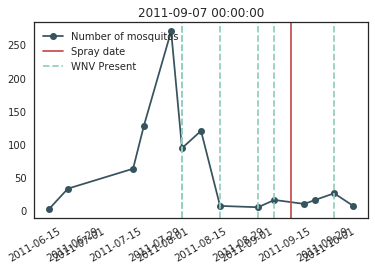

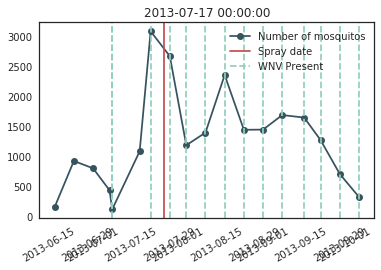

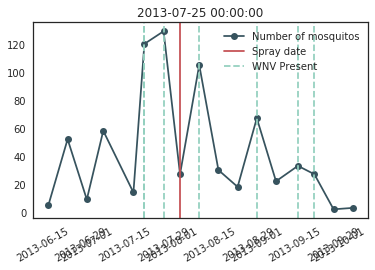

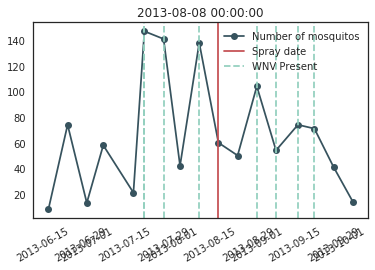

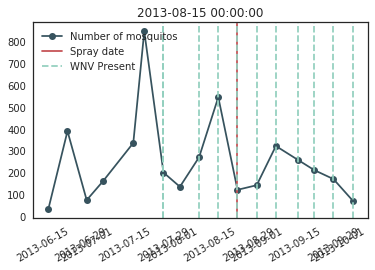

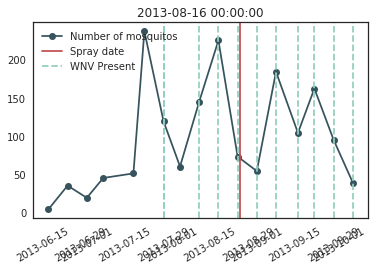

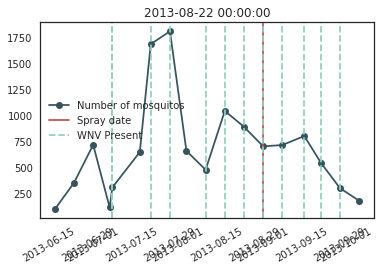

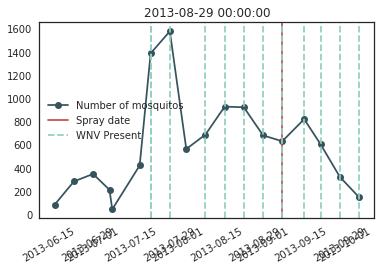

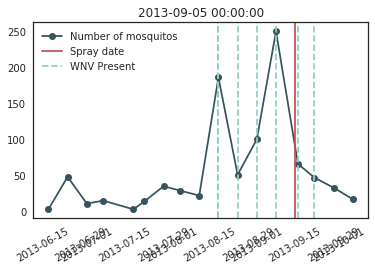

In [30]:
# Drop columns to create a DataFrame from the full training set
df_train_small = df_train.copy()
df_train_small[y_count_label] = y_count
df_train_small[y_wnv_label] = y_wnv
df_train_small.drop(columns=['Latitude','Longitude','Week'], inplace=True)


for date,traps in spray.items():
    min_date = date - timedelta(days=100)
    max_date = date + timedelta(days=100)
    df_train_area = df_train_small[df_train_small["Trap"].isin(traps)].copy()
    df_train_area.drop(columns='Trap',inplace=True)
    df_train_area = df_train_area[df_train_area['Date'] >= min_date].copy()
    df_train_area = df_train_area[df_train_area['Date'] <= max_date].copy()
    df_train_area = df_train_area.groupby(['Date'], as_index=False).sum().reindex()
    df_train_area['WnvPresent'] = (df_train_area['WnvPresent'] > 0).astype(int)
    dates = list(df_train_area.loc[(df_train_area['WnvPresent'] > 0),"Date"])
    
    plt.figure()
    plt.plot(figsize=(10, 20))
    ax = plt.gca()
    ax.set_title(str(date))
    df_train_area.plot(x='Date', y='NumMosquitos', c=colors[0], marker='o', label = "Number of mosquitos", ax=ax);
    ax.axvline(x=date, c='r', label="Spray date")
    label = True
    for w in dates:
        if label:
            ax.axvline(x=w, c=colors[5], linestyle="dashed", label="WNV Present")
            label = False
        ax.axvline(x=w, c=colors[5], linestyle="dashed")
    ax.set_xlabel('')    
    ax.set_ylabel('')
    ax.legend(); 


### <span style='color:#3b748a'>Days since last emptied</span>

<ul>
    <li><span style='color:#4095b5'>Since there are traps in the test set but not in the train set, we need to make some inferences. We chose to start by clustering the traps.</span></li>
    <li><span style='color:#4095b5'>Set the maximum "Since emptied" to be 365.</span></li>
    <li><span style='color:#4095b5'>There must be a better way to slice the DataFrames....</span></li>
    <li><span style='color:#4095b5'>Doesn't seem to help right now, but keeping it in case we create something else that makes it so this helps.</span></li>
        
</ul>

In [31]:
# For each trap, calculate days since it was emptied
# There must be a more elegant way to do this using slicing, but I couldn't figure it out quickly.

do_days_since_empty = False
if do_days_since_empty:
    df_traps = pd.DataFrame(list(set(df_train['Trap']) | set(df_kaggle['Trap'])), columns=['Trap'])
    df_traps

    traps = list(df_traps['Trap'])
    dates = []
    for t in traps:
        dates_train = set(df_train.loc[df_train['Trap'] == t, 'Date'])
        dates_kaggle = set(df_kaggle.loc[df_kaggle['Trap'] == t, 'Date'])
        dates.append(dates_train | dates_kaggle)

    df_traps['Dates'] = dates
    df_traps.set_index(['Trap'], inplace=True)

    # Now for each train and kaggle record, add a column of last day checked
    emptied = []
    for i in range(df_train.shape[0]):
        trap = df_train.loc[i,"Trap"]
        date = df_train.loc[i,"Date"]   
        dates = [i for i in set(df_traps.loc[trap]["Dates"]) if i < date]
        if len(dates) > 0:
            emptied_i = min((date - max(dates)).days,365)
        else:
            emptied_i = 365
        emptied.append(emptied_i)

    df_train["Emptied"] = emptied

    emptied = []
    for i in range(df_kaggle.shape[0]):
        trap = df_kaggle.loc[i,"Trap"]
        date = df_kaggle.loc[i,"Date"]   
        dates = [i for i in set(df_traps.loc[trap]["Dates"]) if i < date]
        if len(dates) > 0:
            emptied_i = min((date - max(dates)).days,365)
        else:
            emptied_i = 365
        emptied.append(emptied_i)

    df_kaggle["Emptied"] = emptied


### <span style='color:#3b748a'>Cluster the traps</span>
<ul>
    <li><span style='color:#4095b5'>Traps in train (orange).</span>
    <li><span style='color:#4095b5'>Traps in train with West Nile present (blue).</span>
    <li><span style='color:#4095b5'>Traps in Kaggle test (purple).</span>
</ul>
<img src="../images/trap-map.jpg" alt="traps" alt="Trap locations" width=400/>
<center><span style='color:#4095b5'>Map of traps and West Nile</span></center>

In [32]:
do_clusters = False

if do_clusters:
    # Combine train and test traps
    traps = df_train[['Latitude', 'Longitude']].copy()
    train_rows = traps.shape[0]
    traps = traps.append(df_kaggle[['Latitude', 'Longitude']])

    # Call k-means to cluster the traps
    kmeans = KMeans(n_clusters=50, random_state=1929)
    model = kmeans.fit(traps)
    centroids = pd.DataFrame(model.cluster_centers_, columns = ['x1', 'x2'])

    # Plot the traps and centroids

    ax = traps.plot(    
        kind="scatter", 
        y='Latitude', x='Longitude',
        figsize=(10,8),
        c = colors[3]
    )

    centroids.plot(
        kind="scatter", 
        y="x1", x="x2", 
        marker="*", s=550,
        color = colors[1], 
        ax=ax
    );

    # Add the cluster information to each row
    traps['Cluster'] = kmeans.labels_
    df_train['Cluster'] = (traps['Cluster'][0:train_rows]).astype(object)
    df_kaggle['Cluster'] = (traps['Cluster'][train_rows:]).astype(object)

<img src="../images/clusters.jpg" alt="clusters" alt="Clusters" width=500/>
<center><span style='color:#4095b5'>Clusters calculated with KMeans</span></center>

#### <span style='color:#4095b5'>Create a table of Number of Mosqitos per week</span>

<span style='color:#52aec9'>Useful for plotting and mapping and feature engineering.</span>

In [33]:
num_mosquito_cols = ['Year', 'Week']
df_num_mosquitos = df_train[num_mosquito_cols].copy()
df_num_mosquitos[y_count_label] = y_count
df_num_mosquitos = df_num_mosquitos.groupby(by = ['Year','Week'], as_index=False).sum()
print("Number of Weeks with mosquito counts: {}".format(df_num_mosquitos.shape[0]))
df_num_mosquitos.head()
# df_num_mosquitos.to_csv('../data/weekly_num_mosq.csv')

Number of Weeks with mosquito counts: 65


,Year,Week,NumMosquitos
0,2007,22,40
1,2007,23,127
2,2007,26,301
3,2007,27,240
4,2007,28,1103


 ### <span style='color:#3b748a'>Function to make dummies</span>

In [34]:
# Let's make dummies for the categorical data
def make_dummies(train, test, cols):

    train = train[X_cols].copy()
    test = test[X_cols].copy()
    
    train = pd.get_dummies(train)
    test = pd.get_dummies(test)

    # Get dummies could leave us with mismatched columns
    # Make sure we have mathcing columns in the train and kaggle DataFrames

    cols_train = train.columns
    cols_test = test.columns

    for c in cols_train:
        if c not in cols_test:
            test[c] = 0

    for c in cols_test:
        if c not in cols_train:
            train[c] = 0

    columns = sorted(train.columns)
    train = train[columns]
    test = test[columns]

    if train.shape[1] != test.shape[1]:
        print("Train and Test don't have same # columns: {} {}".format(train.shape[1], test.shape[1]))

    # Having made dummies, we now have lots and lots of columns
    print("There are {} columns and {} categorial columns."
          .format(train.shape[1],
                  train.select_dtypes([np.object]).shape[1]))
    
    return [train, test]

### <span style='color:#37535e'><b>Feature engineering</b></span><br />

<span style='color:#3b748a'><b>Traps</b></span><br />
<span style='color:#3b748a'>For each trap, we calculated two sets: the days it was emptied and the days it was sprayed. The first one is fairly straightforward to compute from the observations. The second took more work as we needed to create a distance metric to determine if a trap was in an area covered by spraying. From these, we were able to add columns to the observations and predictions: Days since sprayed (Since_sprayed) and Days since emptied (Since_emptied).</span>
<br /><br />

<span style='color:#3b748a'><b>Clusters</b></span><br />
<span style='color:#3b748a'>Considering how account for the fact that we had to predict data for traps not in the observation set, we decided to see if we could create a category column in the observation and prediction data for "clusters" of traps. An elegant process and map, but unfortunately did not appear to give us any extra benefit in the end. The latitude and longitude measures were sufficient.</span>
<br /><br />

<span style='color:#3b748a'><b>Make dummies</b></span><br />
<span style='color:#3b748a'>While much of the data is numerical, there is some categorical data (Species, in particular) that we needed to make dummy columns for. As always, we had to ensure that both the observations and predictions had the same dummies.</span>


<hr>
<a name="step4"></a>
## <span style='color:#37535e'>Model the data</span>
 <span style='color:#3b748a'>For each record in the test set, you should predict a real-valued probability that WNV is present.</span>

<ul>
    <li><span style='color:#4095b5'>First, we have to predict HOW MANY mosquitoes of each species will be in a trap on a given date.</span></li>
    <li><span style='color:#4095b5'>Then we have to predict the probablity that there will be West Nile virus present based on those counts.</span></li>
</ul> 

### <span style='color:#3b748a'>We had two models:</span>
<ul>
    <li><span style='color:#4095b5'>For both steps, we tried a Grid Search on a Pipeline.</span></li>
<li><span style='color:#4095b5'>Computing a dataframe with empirical probalities of WNV | # in trap &amp; species. See <a href="#step7"><span style='color:#4095b5'>the section below</span></a>.</span></li>
</ul>

### <span style='color:#3b748a'>The MASSIVE Pipeline</span>
<ul>
    <li><span style='color:#4095b5'>The Pipeline function takes a set of features and a model and runs grid search over their parameters on the train/test data for the specified model.</span></li>
    <li><span style='color:#4095b5'>Adjustment of the parameter ranges is not automated at this time. Each time it runs, we check to see if a parameter bound has been hit and adjust the value ranges.</span></li>
    <li><span style='color:#4095b5'>The function returns information about the best model, but not the model itself. Perhaps to be included in the future.</span></li>
</ul>

In [35]:
def run_pipline(items, X_train, X_test, y_train, y_test):

    # Add a pipe, add a param !
    pipe_items = {
        'ss' : StandardScaler(),
        'pf' : PolynomialFeatures(),

        'lr' : LinearRegression(),
        'rd' : Ridge(),
        'la' : Lasso(),
        'en' : ElasticNet(), 
        'gr' : GaussianProcessRegressor(),
        'rf' : RandomForestRegressor(),
        'gb' : GradientBoostingRegressor(),
        'ab' : AdaBoostRegressor(),
        'svm' : SVR(),
        'knn' : KNeighborsRegressor(),
        
        'lgr' : LogisticRegression(),
        'rfc' : RandomForestClassifier(),
        'gbc' : GradientBoostingClassifier(),
        'abc' : AdaBoostClassifier(),
        'svc' : SVC(),
        'knnc' : KNeighborsClassifier()

    }

    # Include at least one param for each pipe item
    param_items = {
        'ss' : {
            'ss__with_mean' : [False]
        },
        'pf' : {
            'pf__degree' : [2]
        },
        'lr' : {
            'lr__n_jobs' : [1]
        },
        'rd' : {
             'rd__alpha' : [55.0, 60.0, 65.0]
        },
        'la' : {
             'la__alpha' : [0.005, 0.0075, 0.01], 
             'la__max_iter' : [100000]
        },
        'en' : {
             'en__alpha' : [0.01, 0.02, 0.4], 
             'en__l1_ratio' : [.8, 1, 1.2]
        },
        'gr' : {
            'gr__alpha' : [1, 0.1]
        },
        'rf' : {
            'rf__n_estimators' : [7, 8, 9]
        },
        'gb' : {
            'gb__n_estimators' : [325, 330, 335]
        },
        'ab' : {
            'ab__n_estimators' : [65, 70, 75]
        },
        'svm' : {
            'svm__kernel' : ['linear','poly']
        },
        'knn' : {
            'knn__n_neighbors' : [3, 4, 5, 6]
        },
        'lgr' : {
            'lgr__C' : [.04, .05, .06],
            'lgr__penalty' : ['l1','l2']
        },
        'rfc' : {
            'rfc__n_estimators' : [7, 8, 9, 10]
        },
        'gbc' : {
            'gbc__n_estimators' : [35, 40, 45]
        },
        'abc' : {
            'abc__n_estimators' : [80, 90, 100]
        },
        'svc' : {
            'svc__kernel' : ['linear','poly']
        },
        'knnc' : {
            'knnc__n_neighbors' : [35, 40, 45, 50]
        }

    }

    # Create the parameters for GridSearch
    params = dict()
    for i in items:
        for p in param_items[i]:
            params[p] = param_items[i][p]

    # Create the pipeline
    pipe_list = [(i,pipe_items[i]) for i in items]
    print("Using:")
    for p in pipe_list:
        print("\t" + str(p[1]).split('(')[0])
    pipe = Pipeline(pipe_list)

    # Grid search
    gs = GridSearchCV(pipe, param_grid=params, verbose=1)
    gs.fit(X_train, y_train)

    # Print the results
    train_params = gs.best_params_
    train_score = gs.best_score_
    y_test_hat = gs.predict(X_test)
    test_score = gs.score(X_test, y_test)

    for k in train_params:
        print("{}: {}".format(k,train_params[k]))

    print("Train score: {} Test score {}".format(train_score, test_score))
    print("")

    return train_score, test_score, y_test_hat, train_params

### <span style='color:#3b748a'>Prepare for REGRESSION to predict <span style="font-family:monospace">NumMosquitos</span></span>
<ul>
    <li><span style='color:#4095b5'>Use a subest of columns: The columns are <span style="font-family:monospace">['Week', 'Year', 'Species', 'Latitude', 'Longitude']</span></span></li>
    <li><span style='color:#4095b5'>Make dummies on the columns (only <span style="font-family:monospace">'Species'</span> at the moment).</span></li>
    <li><span style='color:#4095b5'>Do a train/test split on the training data.</span></li>
</ul>

In [36]:
# Let's start with a few features
X_cols = list(df_train.columns)
X_cols.remove('Date')
X_cols.remove('Trap')

if do_days_since_empty:
    X_cols.remove('Emptied')

if do_clusters:
    X_cols.remove('Latitude')
    X_cols.remove('Longitude')
    
print("The columns are {}".format(X_cols))
[X_cols_train, X_cols_kaggle] = make_dummies(df_train, df_kaggle, X_cols)

# Test/train split of "full training" data
X_train, X_test, y_train, y_test = train_test_split(X_cols_train, y_count, random_state=42)

The columns are ['Species', 'Latitude', 'Longitude', 'Week', 'Year', 'SinceEmptied']
There are 13 columns and 0 categorial columns.


### <span style='color:#3b748a'>Call the pipeline to use REGRESSION to predict <span style="font-family:monospace">NumMosquitos</span></span>
<ul>
    <li><span style='color:#4095b5'>Choose a regression model.</span></span></li>
    <li><span style='color:#4095b5'>Use <span style="font-family:monospace">StandardScaler</span>.</span></li>
    <li><span style='color:#4095b5'>Update params values based on grid search and repeat (not automated).</span>       <li><span style='color:#4095b5'>Fudge the predicted data -- <span style="font-family:monospace">NumMosquitos</span> is non-negative and if duplicate rows in Kaggle test data, all but last row should have 50 mosquitos.</span></li>
</ul>

In [37]:
# Regression models
# 'lr' : LinearRegression(),
# 'rd' : Ridge(),
# 'la' : Lasso(),
# 'en' : ElasticNet(), 
# 'gr' : GaussianProcessRegressor(),
# 'rf' : RandomForestRegressor(),
# 'gb' : GradientBoostingRegressor(),
# 'ab' : AdaBoostRegressor(),
# 'svm' : SVR(),
# 'knn' : KNeighborsRegressor(),

models = ['lr','rd','la','en','rf','gb','ab','knn'] # 'gr',svm']

model_solns = {}
for m in models:
    pipe_items = ['ss', m]
    [train_score, test_score, y_test_hat, best_params] = run_pipline(pipe_items,
                                                            X_train, X_test, 
                                                            y_train, y_test)
    model_solns[idx] = {'model': m, 
                        'train_score': train_score, 'test_score': test_score, 
                        'best_params': best_params, 'y_test_hat' : y_test_hat}

Using:
	StandardScaler
	LinearRegression
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s finished


lr__n_jobs: 1
ss__with_mean: False
Train score: 0.10811661571187338 Test score 0.10130265122270145

Using:
	StandardScaler
	Ridge
Fitting 3 folds for each of 3 candidates, totalling 9 fits
rd__alpha: 55.0
ss__with_mean: False
Train score: 0.10810738232038646 Test score 0.10247145013167802

Using:
	StandardScaler
	Lasso
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.8s finished


la__alpha: 0.005
la__max_iter: 100000
ss__with_mean: False
Train score: 0.10810734160002722 Test score 0.10232835988365217

Using:
	StandardScaler
	ElasticNet
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.9s finished


en__alpha: 0.01
en__l1_ratio: 1.2
ss__with_mean: False
Train score: 0.10811588586348733 Test score 0.10231437783765253

Using:
	StandardScaler
	RandomForestRegressor
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s finished


rf__n_estimators: 9
ss__with_mean: False
Train score: 0.5234339946148628 Test score 0.5839633840040168

Using:
	StandardScaler
	GradientBoostingRegressor
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    7.3s finished


gb__n_estimators: 335
ss__with_mean: False
Train score: 0.5419676872590317 Test score 0.5687026208106056

Using:
	StandardScaler
	AdaBoostRegressor
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.8s finished


ab__n_estimators: 65
ss__with_mean: False
Train score: 0.30207284857980027 Test score 0.2922199680987865

Using:
	StandardScaler
	KNeighborsRegressor
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   12.3s finished


knn__n_neighbors: 6
ss__with_mean: False
Train score: 0.46369180524680864 Test score 0.5310807303716555



### <span style='color:#3b748a'>Choose best REGRESSION to predict <span style="font-family:monospace">NumMosquitos</span></span>
<ul>
    <li><span style='color:#4095b5'>The best regression model is <span style="font-family:monospace">GradientBoostingRegressor</span>.</span></li>
    <li><span style='color:#4095b5'>Using the best model, predict the <span style="font-family:monospace">NumMosquitos</span> for the Kaggle test set.</span></li>
    <li><span style='color:#4095b5'>Do a little post-processing to the predicted counts.</span></li>
</ul>

#### <span style='color:#4095b5'>Fit the best model to the training set.</span>

In [38]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('gb', GradientBoostingRegressor())
])
params_grid_cv = {
    'ss__with_mean' : [False],
    'gb__n_estimators' : [325, 330, 335]
}
 
gs = GridSearchCV(pipe, param_grid=params_grid_cv, verbose=1)
gs.fit(X_train, y_train)

# Predict the sales price of the Kaggle data
y_hat = gs.predict(X_test)

print("Train score: {} Test score: {}".format(gs.score(X_train,y_train),gs.score(X_test,y_test)))

# With aggregating observation rows:
# Train score: 0.9837199209535019 Test score: 0.9560608932255188

# Train score: 0.5849628964570315 Test score: 0.5677847042206758

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.8s finished


Train score: 0.5851552732920864 Test score: 0.5686915500794443


#### <span style='color:#4095b5'>Fit the model to the Kaggle set and add the predictions to the Kaggle test DataFrame.</span>

In [39]:
# Fit full train data to predict kaggle
# Didn't help
# gs.fit(X_cols_train,y_count)

# Now predict how many mosquitoes will be in each of the kaggle tests given this
df_train[y_count_label] = y_count
df_kaggle[y_count_label] = gs.predict(X_cols_kaggle)

#### <span style='color:#4095b5'>Duplicate rows should have 50 mosquitos.</span>

In [40]:
# 50 in all duplicates except the "last" duplicate
# Replace negative values with 0

# Remove the Id
cols = list(df_kaggle.columns)
cols.remove('Id')

# Indices of duplicates for the first occurrence
duplicate_indices = df_kaggle[df_kaggle.duplicated(cols) == True].index

# There are 50 mosquitos in the "previous" record
for i in duplicate_indices:
    df_kaggle.loc[i-1,y_count_label] = 50


#### <span style='color:#4095b5'>The number of mosquitos should be non-negative.</span>

In [41]:
df_kaggle.loc[(df_kaggle[y_count_label] < 0), y_count_label] = 0

### <span style='color:#3b748a'>Prepare for CLASSIFICATION to predict if West Nile is present given the <span style="font-family:monospace">NumMosquitos</span>.</span>
<ul>
    <li><span style='color:#4095b5'>Use a subest of columns: The columns are <span style="font-family:monospace">['Week', 'Species', 'Latitude', 'Longitude', 'Year', 'NumMosquitos']</span></span></li>
    <li><span style='color:#4095b5'>Make dummies on the columns (only <span style="font-family:monospace">'Species'</span> at the moment).</span></li>
    <li><span style='color:#4095b5'>Do a train/test split on the training data.</span></li>
</ul>

In [42]:
# Let's start with a few features
X_cols = list(df_train.columns)
X_cols.remove('Date')
X_cols.remove('Trap')
# X_cols.remove('Year')

if do_clusters:
    X_cols.remove('Latitude')
    X_cols.remove('Longitude')

print("The columns are {}".format(X_cols))
[X_cols_train, X_cols_kaggle] = make_dummies(df_train, df_kaggle, X_cols)

# Test/train split of "full training" data
X_train, X_test, y_train, y_test = train_test_split(X_cols_train, y_wnv, random_state=42)

The columns are ['Species', 'Latitude', 'Longitude', 'Week', 'Year', 'SinceEmptied', 'NumMosquitos']
There are 14 columns and 0 categorial columns.


### <span style='color:#3b748a'>Call the pipeline to use CLASSIFICATION to predict if West Nile is present given the <span style="font-family:monospace">NumMosquitos</span>.</span>
<ul>
    <li><span style='color:#4095b5'>Choose a classification model.</span></span></li>
    <li><span style='color:#4095b5'>Use <span style="font-family:monospace">StandardScaler</span>.</span></li>
    <li><span style='color:#4095b5'>Update params values based on grid search and repeat (not automated).</span></li>
</ul>

In [43]:
# Classification models
#         'lgr' : LogisticRegression(),
#         'rfc' : RandomForestClassifier(),
#         'gbc' : GradientBoostingClassifier(),
#         'abc' : AdaBoostClassifier(),
#         'svc' : SVC(),
#         'knnc' : KNeighborsClassifier()

# Decide what to put into the pipline, grid searh, and save the "best" for each grid search
models = ['lgr','rfc','gbc','abc','knnc']
# other = ['pf','ss']

# After some initial tests, these seem like the best to pursue further
# models = ['lgr']

model_solns = {}
for m in models:
    pipe_items = ['ss', m]
    [train_score, test_score, y_test_hat, best_params] = run_pipline(pipe_items,
                                                            X_train, X_test, 
                                                            y_train, y_test)
    model_solns[idx] = {'model': m, 
                        'train_score': train_score, 'test_score': test_score, 
                        'best_params': best_params, 'y_test_hat' : y_test_hat}


Using:
	StandardScaler
	LogisticRegression
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   20.4s finished


lgr__C: 0.04
lgr__penalty: l1
ss__with_mean: False
Train score: 0.947074501840335 Test score 0.9489912447658927

Using:
	StandardScaler
	RandomForestClassifier
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.9s finished


rfc__n_estimators: 10
ss__with_mean: False
Train score: 0.9421246351059779 Test score 0.9451846212409593

Using:
	StandardScaler
	GradientBoostingClassifier
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.2s finished


gbc__n_estimators: 40
ss__with_mean: False
Train score: 0.9473283411600457 Test score 0.9486105824133994

Using:
	StandardScaler
	AdaBoostClassifier
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.1s finished


abc__n_estimators: 100
ss__with_mean: False
Train score: 0.9465668232009138 Test score 0.9489912447658927

Using:
	StandardScaler
	KNeighborsClassifier
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   15.7s finished


knnc__n_neighbors: 50
ss__with_mean: False
Train score: 0.947074501840335 Test score 0.9489912447658927



<hr>
<a name="step5"></a>
## <span style='color:#37535e'>Evaluate the model</span>

### <span style='color:#3b748a'>Choose best CLASSIFICATION to predict <span style="font-family:monospace">NumMosquitos</span></span>
<ul>
    <li><span style='color:#4095b5'>The best classification model is <span style="font-family:monospace">LogisticRegression</span>.</span></li>
    <li><span style='color:#4095b5'>Using the best model, predict the probability of West Nile Virus.</span></li>
</ul>

#### <span style='color:#4095b5'>Fit the model to the training set.</span>

In [44]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lgr', LogisticRegression())
])
params_grid_cv = {
    'ss__with_mean' : [False],
    'lgr__C' : [.04, .05, .06],
    'lgr__penalty' : ['l1','l2']
}

        
gs = GridSearchCV(pipe, param_grid=params_grid_cv, verbose=1)
gs.fit(X_train, y_train)

# Predict the sales price of the Kaggle data
y_test_hat = gs.predict(X_test)
y_test_proba = gs.predict_proba(X_test)
df_test_proba = pd.DataFrame(y_test_proba)
y_test_proba = df_test_proba[1]

print("Train score: {} Test score: {}".format(gs.score(X_train,y_train),gs.score(X_test,y_test)))
print("ROC AUC score: {}".format(roc_auc_score(y_test, y_test_proba)))

# Train score: 0.947074501840335 Test score: 0.9489912447658927
# ROC AUC score: 0.779049996707198

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   25.1s finished


Train score: 0.947074501840335 Test score: 0.9489912447658927
ROC AUC score: 0.7801246475205201


### <span style='color:#37535e'><b>Modeling</b></span><br />

<span style='color:#3b748a'><b>The main objective</b></span>
<span style='color:#3b748a'>For each entry in the predictions dataset, we need to predict the probability that West Nile will be observed.</span>

<span style='color:#3b748a'><b>Model 1: Regression/Classification with post-processing</b></span><br />
<span style='color:#3b748a'>The initial idea for a model was to break it into two steps: first predict how many of each species would be in a trap for each entry in the predictions data set, then from that predict the probability of West Nile.</span>
<br /><br />

<span style='color:#3b748a'>For the first model, we took a subset of the features('Week', 'Year', 'Species', 'Latitude', 'Longitude'), did a train/test split on the observed data, and then ran a grid search including scaling using eight different regression algorithms on the data in order to predict HOW MANY mosquitos of each species will be present. The best regressor was the <span style="font-family:monospace">GradientBoostingRegressor</span>. Once a model was fit and the parameters tuned, we then made a prediction.</span>
<br /><br />

<span style='color:#3b748a'>We then tuned this mosquito count prediction in two ways. First, we rounded up to 0 any negative predictions. Second, we made the observation that there were 1533 duplicate rows in the Kaggle test data set. ASSUMING, that this is for the same reasons there were duplicate rows in the observation set, we set the predicted number of mosquitos to be 50 for the duplicate row (except for the last duplicate in each repetition.</span>
<br /><br />

<span style='color:#3b748a'>Given our new "feature" of "Number of Mosquitos", we then took a subset of the features('Week', 'Year', 'Species', 'Latitude', 'Longitude', 'NumMosquitos'), did a train/test split on the observed data, and then ran a grid search including scaling using six different classification algorithms on the data in order to predict the PRESENCE of West Nile Virus for each Kaggle test observation. The best classification was <span style="font-family:monospace">LogiticRegression</span>. Once a model was fit and the parameters tuned, we then make a prediction on the probability that for the date/trap/species there will be a positive test for West Nile Virus.</span>
<br /><br />

<span style='color:#3b748a'>We then tuned this probability prediction by setting the prediction to 0.0 for all species OTHER that the three in which West Nile was observed. (This is done below right now, but could be moved up.)</span>
<br /><br />
<span style='color:#3b748a'>This gave an AUC ROC of 0.78. On Kaggle, the scores are 0.72432 and 0.73532. (../data/model_preds_2018-09-20 17/01/32.671403.csv)
</span>

<br /><br />

<span style='color:#3b748a'><b>Model 2: Percentage model</b></span><br />
<span style='color:#3b748a'>The percentage model leverages the modeling done above with respect to the prediction of the number of mosquitoes present in the Kaggle test traps.  We then sought to create data from our data files so that we could look up the probability of the presence of West Nile given the species found in the that trap and the number of mosquitoes present in the trap.</span>
<br /><br />
<span style='color:#3b748a'>
There are three species of mosquitoes that carried West Nile virus in our observations.  We summed the data available to create a matrix of the number of observations where the columns are the species and the rows are the number of mosquitoes found in the trap.  We then created a second, similar matrix except that the observations where only the times that West Nile virus was present.  The final matrix is the division of the second by the first.  This gives the probability of finding West Nile virus in a trap given the number of mosquitoes in the trap of a certain species.</span>
<br /><br />
<span style='color:#3b748a'>
The results were choppy by number of mosquitoes but generally followed an upward trend.  For the three species where West Nile virus was present, we then used linear regression tools to smooth the probabilities (least squares line of best fit).  By linking the Kaggle test data (species plus projected mosquitoes using GradientBosstingRegression) to these smoothed probabilities, we could complete a submission file.
Using this final, smoothed result gave an AUC ROC of 0.71 (../data/sub0007.csv).</span>
<br /><br />

<hr>
<a name="step6"></a>
## <span style='color:#37535e'>Answer the question</span>
###  <span style='color:#3b748a'>Output the results to upload to Kaggle.</span>

#### <span style='color:#4095b5'>Fit the model to the Kaggle set and add the predictions (probability of West NIle) to the Kaggle test DataFrame.</span>

In [45]:
# Fit full train data to predict kaggle
# Didn't help
# gs.fit(X_cols_train,y_wnv)

y_kaggle_proba = gs.predict_proba(X_cols_kaggle)
y_kaggle = list(y_kaggle_proba[:,1])

In [46]:
# Create dataframe for Kaggle submission
# Make the ID the index
df_kaggle['WnvPresent'] = y_kaggle
df_kaggle.loc[(df_kaggle['Species'].isin(species_wnv) == False), 'WnvPresent'] = 0

In [47]:
y_kaggle = df_kaggle['WnvPresent']

In [48]:
df_kaggle.set_index("Id", inplace=True)
df_soln = pd.DataFrame(df_kaggle.index)
df_soln['WnvPresent'] = y_kaggle

# Predict no Wnv if not one of three species
df_soln.set_index(['Id'], inplace=True)

In [49]:
# Write predicted Kaggle solution out to a file
now = str(datetime.now())
f'predictions_{now}'
df_soln.to_csv(f'../data/model_preds_{now}.csv')

<hr>

<a name="step7"></a>
## <span style='color:#37535e'>VII. More modeling</span>

<span style='color:#3b748a'>We wanted to merge the notebooks, but it was taking too long. Other work is included here instead.</span>

### <span style='color:#3b748a'>Computing a dataframe with empirical probalities of WNV | # in trap &amp; species</span>


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import time

import scipy.stats as stats

from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 999)

%matplotlib inline

In [ ]:
kaggle_train = pd.read_csv('../data/train.csv')
kaggle_test = pd.read_csv('../data/test.csv')

X_k_train = kaggle_train[['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos','WnvPresent']].copy()
X_cols = list(X_k_train.columns.drop(['WnvPresent','NumMosquitos']))

X_k_train['Date'] = pd.to_datetime(kaggle_train['Date'])

X_k_train.head()

In [ ]:
spec = list(set(X_k_train['Species']))
df = pd.DataFrame(0, index = range(51), columns = spec)
df.head()

In [ ]:
def add_to_df(df_in, species, yn_var):
    df_in.loc[yn_var,species] += 1
    return(df_in)

for each in range(len(X_k_train)):  
    df = add_to_df(df, X_k_train.loc[each,'Species'], X_k_train.loc[each,'NumMosquitos'])

df.head()       # number of occurance of species / trap in the training data

In [ ]:
def add_to_df2(df_in, species, NumM, Wnv):
    df_in.loc[NumM,species] += Wnv
    return(df_in)

df2 = pd.DataFrame(0, index = range(51), columns = spec)
for each in range(len(X_k_train)):  
    df2 = add_to_df2(df2, X_k_train.loc[each,'Species'], X_k_train.loc[each,'NumMosquitos'],X_k_train.loc[each,'WnvPresent'])

df2.head()           # number of WNV Present occurances by Species and Number in trap

In [ ]:
df3 = df2.copy()
for i in range(len(df2)):
    for j in df2.columns:
        if df.loc[i,j] == 0:
            df3.loc[i,j] = 0
        else:
            df3.loc[i,j] = df2.loc[i,j] / df.loc[i,j]
            
df3.head()     # Empirical probabilities of WNV present given Species and Number of Mosquitos in trap

#### <span style='color:#4095b5'>Creating a regression to smooth the probabilities given species &amp; trap number</span>

In [ ]:
X = list(range(0,51))
y = df3['CULEX PIPIENS']
slope, intercept, r_value, p_value, std_err = stats.linregress(X,y)


probs = pd.DataFrame(0, index = range(51), columns = set(kaggle_test['Species']))
prob = []
for each in X:
    prob.append(each*slope+intercept)

    prob[0] = 0
probs['CULEX PIPIENS'] = prob

y = df3['CULEX PIPIENS/RESTUANS']
slope, intercept, r_value, p_value, std_err = stats.linregress(X,y)
prob = []
for each in X:
    prob.append(each*slope+intercept)
prob[0] = 0
probs['CULEX PIPIENS/RESTUANS'] = prob

y = df3['CULEX RESTUANS']
slope, intercept, r_value, p_value, std_err = stats.linregress(X,y)
prob = []
for each in X:
    prob.append(each*slope+intercept)
prob[0] = 0
probs['CULEX RESTUANS'] = prob

probs

#### <span style='color:#4095b5'>Read projected mosquito by trap and species and match each projection data row with a probability</span>

In [ ]:
k = pd.read_csv('../data/pred_mosq.csv')

k['WnvPresent'] = 0

for each in range(len(k)):
    sp = k.loc[each, 'Species']
    num = int(k.loc[each, 'NumMosquitos'])
    k.loc[each, 'WnvPresent'] = probs.loc[num,sp]
    if sp == 'UNSPECIFIED CULEX':
        kaggle_test.loc[each, 'WnvPresent'] = .01

out = k[['Id', 'WnvPresent']]
out.to_csv('../data/sub007.csv', index = False)

#### <span style='color:#4095b5'>Make a couple of graphs for presentation</span>

In [ ]:
# Change labels as needed
ax = df3['CULEX RESTUANS'].plot(kind='line', c='b', figsize = (12,8), label = 'Culex Restuans Raw')
ax = probs['CULEX RESTUANS'].plot(kind='line', c='g', figsize = (12,8), label = 'Culex Restuans Smoothed')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc = 'upper left', fontsize = 18);

<a name="avg_prec"></a>
### <span style='color:#4095b5'>Average precipitation calculations</span>

<span style='color:#4095b5'>This produces a wonderful graphic!</span>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 999)

%matplotlib inline

In [ ]:
weather = pd.read_csv('../data/weather.csv', skipinitialspace=True)

weather['Date'] = pd.to_datetime(weather['Date'])
weather[weather['PrecipTotal'] =='M']
weather.loc[117,'PrecipTotal'] = 0
weather.loc[119,'PrecipTotal'] = 0

weather['year'] = weather['Date'].dt.strftime('%Y')
weather['week'] = weather['Date'].dt.strftime('%W')

In [ ]:
df = pd.DataFrame(pd.to_numeric(weather['year']))
df['week'] = pd.to_numeric(weather['week'])
df['precip'] = pd.to_numeric(weather['PrecipTotal'].replace('  T',0))

df_prec = (df.groupby(by = ['year','week']).mean())
(df.groupby(by = ['year','week']).mean()).to_csv('../data/weekly_precip.csv')
df_prec = df_prec.reset_index()

In [ ]:
train_full = pd.read_csv('../data/train.csv')
train = train_full[['Date', 'NumMosquitos']].copy()
train['Date'] = pd.to_datetime(train['Date'])
train['year'] = train['Date'].dt.strftime('%Y')
train['week'] = train['Date'].dt.strftime('%W')
train['year'] = pd.to_numeric(train['year'])
train['week'] = pd.to_numeric(train['week'])

train = train.drop(['Date'], axis = 1)
(train.groupby(by = ['year','week']).sum()).to_csv('../data/weekly_num_mosq.csv')

df_numb = (train.groupby(by = ['year','week']).sum())
df_numb = df_numb.reset_index()

In [ ]:
full_merge = pd.merge(df_prec, df_numb, how='left', on=['year','week'])
dropna_merge = full_merge.dropna().reset_index()
dropna_merge.head()

#fig = plt.figure(figsize = (12, 6))

figsize=(20, 8)
ax = dropna_merge['NumMosquitos'].plot(kind = 'line', c = 'r', figsize=figsize, label = 'Mosquitos')
ax = (dropna_merge['precip']*10000).plot(kind = 'line', c = 'b', figsize=figsize, label = 'Rain')
plt.axvline(17.5, c = 'grey', lw = 3, ymax = .95, label = "Year Breaks ('07, '09, '11, '13)")
plt.axvline(34.5, c = 'grey', lw = 3, ymax = .95)
plt.axvline(48.5, c = 'grey', lw = 3, ymax = .95)

plt.axvline(45, c = 'g', lw = 1, ls = 'dashed', ymax = .95, label = 'Spray Dates')
plt.axvline(46, c = 'g', lw = 1, ls = 'dashed', ymax = .95)
plt.axvline(54, c = 'g', lw = 1, ls = 'dashed', ymax = .65)
plt.axvline(55, c = 'g', lw = 1, ls = 'dashed', ymax = .65)
plt.axvline(57, c = 'g', lw = 1, ls = 'dashed', ymax = .65)
plt.axvline(58, c = 'g', lw = 1, ls = 'dashed', ymax = .65)
plt.axvline(60, c = 'g', lw = 1, ls = 'dashed', ymax = .65)
plt.axvline(61, c = 'g', lw = 1, ls = 'dashed', ymax = .65)


plt.title('Weekly data showing Number of Mosquitoes Collected in Traps vs Average Daily Rainfall', fontsize = 20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.legend(loc = 'upper right');

<hr>
<a name="step8"></a>
## <span style='color:#37535e'>Future investigations:</span>
<span style="color:#3b748a">Includes but not limited to:
<ul>
<li><span style="color:#3b748a">Re-add dates checked column for each trap.</span></li>
<li><span style="color:#3b748a">Clean up the calculation of Sprayed Date - so messy.</span></li>
<li><span style="color:#3b748a">Re-add a column for time since last observation for each trap.</span></li>
<li><span style="color:#3b748a">Check if every trap was checked on each date.</span></li>
<li><span style="color:#3b748a">Improve distance calculation for determining if a trap was within the spraying radius</span></li>
<br />
<li><span style="color:#3b748a">Investigate hours of daylight.</span></li>
<li><span style="color:#3b748a">Explore the weather data more deeply. Dates, streaks, etc.</span></li>
<li><span style="color:#3b748a">Dig further into spraying data as well.</span></li>
<br />
<li><span style="color:#3b748a">Observations with zero of a species. Should we add an extra row just in case? Will that actaully add any new information?</span></li>
<br />
<li><span style="color:#3b748a">Cleanup spray graphics.</span></li>
<li><span style="color:#3b748a">Are there any interesting linear relationships?</span></li>
<li><span style="color:#3b748a">More graphs of spray and weather and mosquito information over time</span></li>
<li><span style="color:#3b748a">Include distribution of WNV and species over each summer.</span></li>
<br />
<li><span style="color:#3b748a">Tune the regression/classification algorithms and add more?</span></li>
<li><span style="color:#3b748a">Try to fit ExtraTrees, Gamma GLM.</span></li>
<li><span style="color:#3b748a">Investigate unbalanced data and how best to account for it.</span></li>
<li><span style="color:#3b748a">Extend the grid search to search over all combinations of regression/classifications for the two steps in the model.</span>
 <br />
<li><span style="color:#3b748a">Aggregate the observations to predict the # of mosquitos in a top, then split to predict probability of West Nile. If we aggregate, we lose some info. But if we don't aggregate, we run the risk of under-predicting the number of mosquitos. I think we should try aggregating to predict counts, then unaggregating to predict the presence
</span></li>
</ul>
    


<hr>
<a name="step9"></a>
## <span style='color:#37535e'>For reference or possible future use:</span>

In [ ]:
# Calculating the hotspots
def put_t_back(obs_in):
    obs_in = str(obs_in)
    if len(obs_in) == 1:
        obs_out = 'T00'+obs_in
    if len(obs_in) == 2:
        obs_out = 'T0'+obs_in
    if len(obs_in) == 3:
        obs_out = 'T'+obs_in
    return(obs_out)

hotspot_traps = []
for each in traps_with_highest_WNV:
    hotspot_traps.append(put_t_back(each))

In [ ]:
# Calculate disdance from lat/lon

from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in kilometers = 6371. Use 3956 for miles
    return c * r

In [ ]:
# # Only three species have West Nile
# # Export DataFrame to map
# df_wnv = df_train[df_train['WnvPresent'] == 1]
# print("Species with West Nile virus: {}.".format(set(df_wnv['Species'])))

In [ ]:
# Linear Regression can't handle datetime
# X_cols_train['Date'] = X_cols_train['Date'].map(datetime.toordinal)
# X_cols_kaggle['Date'] = X_cols_kaggle['Date'].map(datetime.toordinal)

In [ ]:
# # These are only used for creating the map and not part of the notebook flow

# # Used to plot traps
# df_traps = df_kaggle[['Trap','Latitude','Longitude']]
# df_traps.drop_duplicates(inplace=True)
# df_traps.shape
# df_traps.to_csv(f'../data/traps_kaggle.csv')

# # Get the traps and export to map
# df_traps = df_train[['Trap','Latitude','Longitude']]
# df_traps.drop_duplicates(inplace=True)
# df_traps.shape
# df_traps.to_csv(f'../data/traps_train.csv')


In [ ]:
# # These are only used for creating the map and not part of the notebook flow

# # ['2011-08-29' '2011-09-07' '2013-07-17' '2013-07-25' '2013-08-08'
# #  '2013-08-15' '2013-08-16' '2013-08-22' '2013-08-29' '2013-09-05']

# df_1 = df_spray[df_spray['Date'] == '2011-08-29']
# df_1['DateTime'] = pd.to_datetime(df_1['Date'] + " " + df_1['Time'])
# df_1.to_csv(f'../data/spray-2011-08-29.csv')

# df_3 = df_spray[df_spray['Date'] == '2013-07-17']
# df_3['DateTime'] = pd.to_datetime(df_3['Date'] + " " + df_3['Time'])
# df_3.to_csv(f'../data/spray-2013-07-17.csv')

# df_4 = df_spray[df_spray['Date'] == '2013-07-25']
# df_4['DateTime'] = pd.to_datetime(df_4['Date'] + " " + df_4['Time'])
# df_4.to_csv(f'../data/spray-2013-07-25.csv')

# df_5 = df_spray[df_spray['Date'] == '2013-08-08']
# df_5['DateTime'] = pd.to_datetime(df_5['Date'] + " " + df_5['Time'])
# df_5.to_csv(f'../data/spray-2013-08-08.csv')

# df_6 = df_spray[df_spray['Date'] == '2013-08-15']
# df_6['DateTime'] = pd.to_datetime(df_6['Date'] + " " + df_6['Time'])
# df_6.to_csv(f'../data/spray-2013-08-15.csv')

# df_7 = df_spray[df_spray['Date'] == '2013-08-16']
# df_7['DateTime'] = pd.to_datetime(df_7['Date'] + " " + df_7['Time'])
# df_7.to_csv(f'../data/spray-2013-08-16.csv')

# df_8 = df_spray[df_spray['Date'] == '2013-08-22']
# df_8['DateTime'] = pd.to_datetime(df_8['Date'] + " " + df_8['Time'])
# df_8.to_csv(f'../data/spray-2013-08-22.csv')

# df_8 = df_spray[df_spray['Date'] == '2013-08-29']
# df_8['DateTime'] = pd.to_datetime(df_8['Date'] + " " + df_8['Time'])
# df_8.to_csv(f'../data/spray-2013-08-29.csv')

# df_8 = df_spray[df_spray['Date'] == '2013-09-05']
# df_8['DateTime'] = pd.to_datetime(df_8['Date'] + " " + df_8['Time'])
# df_8.to_csv(f'../data/spray-2013-09-05.csv')

# df_spray_before = read_examine_df("../data/spray 2011-09-07-before-1.csv")
# df_spray_before['DateTime'] = pd.to_datetime(df_spray_before['Date'] + " " + df_spray_before['Time'])
# df_spray_before.to_csv(f'../data/spray-2011-09-07-before-1-d.csv')

# df_spray_before = read_examine_df("../data/spray 2011-09-07-before-2.csv")
# df_spray_before['DateTime'] = pd.to_datetime(df_spray_before['Date'] + " " + df_spray_before['Time'])
# df_spray_before.to_csv(f'../data/spray-2011-09-07-before-2-d.csv')

# df_spray_before = read_examine_df("../data/spray 2011-09-07-after.csv")
# df_spray_before['DateTime'] = pd.to_datetime(df_spray_before['Date'] + " " + df_spray_before['Time'])
# df_spray_before.to_csv(f'../data/spray-2011-09-07-after-d.csv')

# df_spray_before = read_examine_df("../data/spray 2011-09-07-NA.csv")
# df_spray_before['DateTime'] = pd.to_datetime(df_spray_before['Date'] + " " + df_spray_before['Time'])
# df_spray_before.to_csv(f'../data/spray-2011-09-07-NA.csv')

#### <span style='color:#4095b5'>Some weather notes</span>

Found this online for heating degree day calcualtion example:
Anyway, consider a single day, let's say July 1st, when the outside air temperature was 16C throughout the entire day.  A constant temperature throughout an entire day is rather unlikely, I know, but degree days would be a lot easier to understand if the outside air temperature stayed the same...  So, throughout the entire day on July 1st, the outside air temperature (16C) was consistently 1 degree below the base temperature of the building (17C), and we can work out the heating degree days on that day like so:

1 degree * 1 day = 1 heating degree day on July 1st

If, on July 2nd, the outside temperature was 2 degrees below the base temperature, we'd have:

2 degrees * 1 day = 2 heating degree days on July 2nd

Let's look at July 3rd - this was a hotter day, and the outside air temperature was 17C, the same as the base temperature (i.e. 0 degrees below the base temperature).  This gives:

0 degrees * 1 day = 0 heating degree days on July 3nd

On July 4th it was warmer again: 19C.  Again, the number of degrees below the base temperature was zero, giving:

0 degrees * 1 day = 0 heating degree days on July 4th
